This notebook shows how to train an unsupervised MLP. 

In [30]:
using Flux, FFTW, Distributions, Plots, SpecialPolynomials, BenchmarkTools
using BSON: @save
include("./data_generation.jl")
include("./utility_functions.jl")

GSA (generic function with 1 method)

In [8]:
# Some global variables.
const nfft = 100    # Grid size
m = 100000     # Number of data points
ft = plan_fft(zeros((nfft,)),flags=FFTW.MEASURE)    # Fourier transform
ift = plan_ifft(zeros((nfft,)),flags=FFTW.MEASURE)  # Inverse Fourier transform

0.01 * FFTW backward plan for 100-element array of ComplexF64
(dft-ct-dit/10
  (dftw-direct-10/72 "t2bv_10_avx2")
  (dft-direct-10-x10 "n2bv_10_avx2"))

In [4]:
#----------------------------------------------------------------------
# Dataset generators

function supervised_dataset(N::Integer,m::Integer)
    # N is grid size, m is number of data points
    field_amps = [randomHGAmplitude(nfft) for i=1:m]
    y_data = [randomConvexPhase(nfft,Cauchy(0,(10^(-0.5-rand()) * pi/nfft))) for i=1:m]
    fft_amps = [abs.(ft*(field_amps[i] .* exp.(im*2*pi*y_data[i]))) for i=1:m]
    x_data_formatted = hcat((vcat(field_amps[i],fft_amps[i]) for i=1:m)...)
    y_data_formatted = hcat(y_data...)
    return x_data_formatted, y_data_formatted
end

function unsupervised_dataset(N::Integer,m::Integer)
    # N is grid size, m is number of data points
    slm_amps = [randomHGAmplitude(nfft,Normal(),x-> (x==0 ? 1 : 0.01)) for i=1:m]
    cam_amps = [randomHGAmplitude(nfft,Normal(),x-> (x==0 ? 1 : 0.1)) for i=1:m]
    return hcat( (vcat(slm_amps[i],cam_amps[i]) for i=1:m)... )
end

function format_conv_data(data)
    # Reshapes 1D data into the format required for convolutional layers. 
    return convert.(Float32,reshape(data,size(data)[1],1,size(data)[2]))
end

#----------------------------------------------------------------------
# Training loop

function train_and_monitor!(loss,model,batched_data,learning_rate,nit,xs,ys,interval=1)
    ls = []    # Loss, recorded every `interval` iterations. 
    for i=1:nit
        Flux.train!(loss,Flux.params(model),batched_data,Flux.Optimise.Adam(learning_rate))
        (i-1) % interval == 0 && append!(ls,loss(xs,ys))
    end
    return ls
end

train_and_monitor! (generic function with 2 methods)

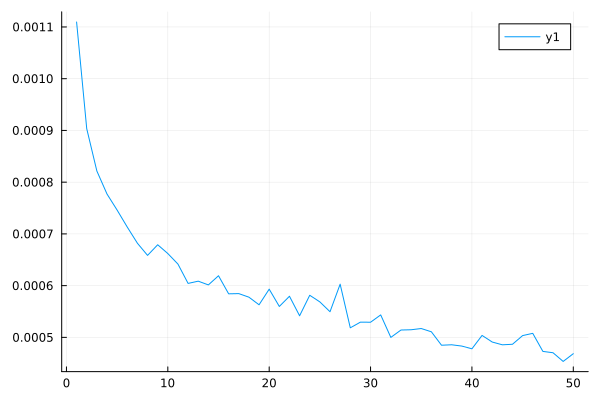

In [5]:
const D = DFTcentered(nfft);   # DFT matrix

# MLP
nHidden = 400
uMLP1 = Chain(Dense(2*nfft,nHidden,relu),Dense(nHidden,nHidden,relu),Dense(nHidden,nHidden,relu),
    Dense(nHidden,nHidden,relu),Dense(nHidden,nHidden,relu), Dense(nHidden,nfft))
loss_uMLP1(x,y) = Flux.Losses.mse( abs.(D * (y[1:nfft,:] .* exp.(2*pi*im*uMLP1(x)))) ,y[nfft+1:end,:])
data = unsupervised_dataset(nfft,m)
batched_data_uMLP1 = Flux.Data.DataLoader((data,data),batchsize=64)
ls1 = train_and_monitor!(loss_uMLP1,uMLP1,batched_data_uMLP1,0.001,50,data,data,1)
plot(ls1)

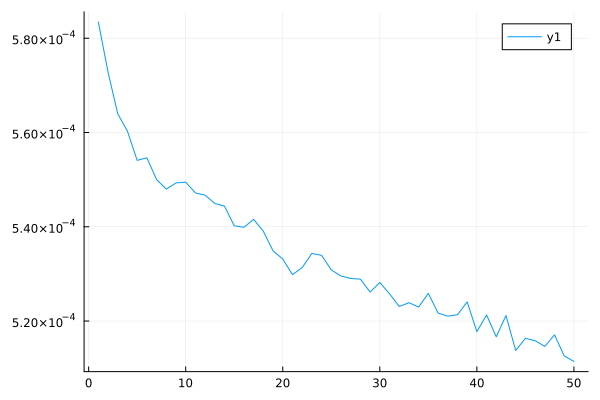

In [7]:
ls2 = train_and_monitor!(loss_uMLP1,uMLP1,batched_data_uMLP1,0.0005,50,data,data,1)
plot(ls2)

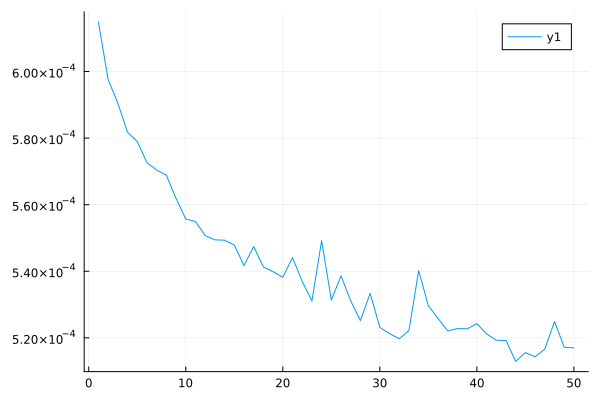

In [12]:
ls3 = train_and_monitor!(loss_uMLP1,uMLP1,batched_data_uMLP1,0.001,50,data,data,1)
plot(ls3)

In [27]:
# Get the metric performance of the model
err = []
for i=1:1000
    ampIn = randomHGAmplitude(nfft,Normal(),x-> (x==0 ? 1.0 : 0.01))
    ampOut = randomHGAmplitude(nfft,Normal(),x-> (x==0 ? 1.0 : 0.1))
    phi = uMLP1(vcat(ampIn,ampOut))
    append!(err,PRerror(ampIn,ampOut,phi,ft,shift=true))
end
mean(err),std(err)

(0.06958382525470913, 0.060706320566041444)

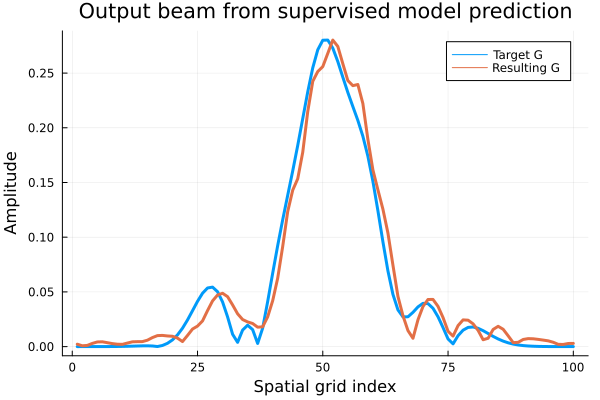

In [17]:
ampIn = randomHGAmplitude(nfft,Normal(),x-> (x==0 ? 1.0 : 0.01))
ampOut = randomHGAmplitude(nfft,Normal(),x-> (x==0 ? 1.0 : 0.1))
phi = uMLP1(vcat(ampIn,ampOut))
plot([ampOut,fftshift(abs.(ft*(ampIn .* exp.(2*pi*im*phi))/10))],labels=["Target G" "Resulting G"], linewidth=3, xlabel="Spatial grid index", ylabel="Amplitude",title="Output beam from supervised model prediction")

In [28]:
PRerror(ampIn,ampOut,phi,ft,shift=true)

0.013380712668932395

In [23]:
# Save the model
@save "uMLP1.bson" uMLP1